# Integration tests for the GoFigr Python client

In [ ]:
import json
from platform import platform
from collections import defaultdict

from gofigr.jupyter import *
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys

from datetime import datetime

from gofigr.widget import *

try:
    import py3Dmol
except:
    print("Warning: running without py3dmol", file=sys.stderr)

START_TIME = datetime.now()
TEST_RESULTS = []

def sync():
    with open("integration_test.json", "w") as f:
        json.dump({
            'platform': platform(),
            'elapsed_seconds': (datetime.now() - START_TIME).total_seconds(),
            'results': TEST_RESULTS
            }, f, indent=4)

def check_text(txt, min_len=10):
    return txt is not None and txt.strip() not in ["N/A", "NA"] and len(txt.strip()) >= min_len

def check_figure(test_name, fig_name, expected_revisions=1):   
    res = defaultdict(lambda: True)
    res["test_name"] = test_name
    res["error"] = None
    
    try:    
        ana = get_extension().publisher.analysis
        fig = ana.get_figure(fig_name, create=False)
        fig.fetch()

        res["elapsed_seconds"] = (datetime.now() - START_TIME).total_seconds()
        res["number_of_revisions"] = len(fig.revisions) == expected_revisions

        for rev in fig.revisions:
            rev.fetch()
            res["notebook_name"] = res["notebook_name"] and \
                check_text(rev.metadata["notebook_name"])
            res["notebook_path"] = res["notebook_path"] and \
                check_text(rev.metadata["notebook_path"]) and os.path.exists(rev.metadata["notebook_path"])
            res["backend"] = res["backend"] and check_text(rev.metadata["backend"], min_len=5)
            res["kernel"] = res["kernel"] and check_text(rev.metadata["kernel"], min_len=5)
            res["python_version"] = res["python_version"] and check_text(rev.metadata["python_version"], min_len=4)
            
            for img in rev.image_data:
                image_key = f"image_{img.format}" + ("_watermark" if img.is_watermarked else "")
                res[image_key] = res[image_key] and len(img.data) > 1000

            for code in rev.code_data:
                txt = code.contents.strip()
                if 'history' not in code.metadata['format']:
                    res["cell_code"] = res["cell_code"] and check_text(txt)
                else:
                    res["history"] = res["history"] and check_text(txt, 50)
                
            for td in rev.text_data:
                txt = td.contents.strip()
                res['text'] = res["text"] and check_text(txt)
                
    except Exception as e:
        res["error"] = str(e)
            
    return dict(res.items())

# MPL: load the extension and publish a figure from the same cell

The gofigr extension is already loaded. To reload it, use:
  %reload_ext gofigr


Text(0.5, 1.0, 'b4948f96-36c8-4a59-afae-6f7624a5c12e')

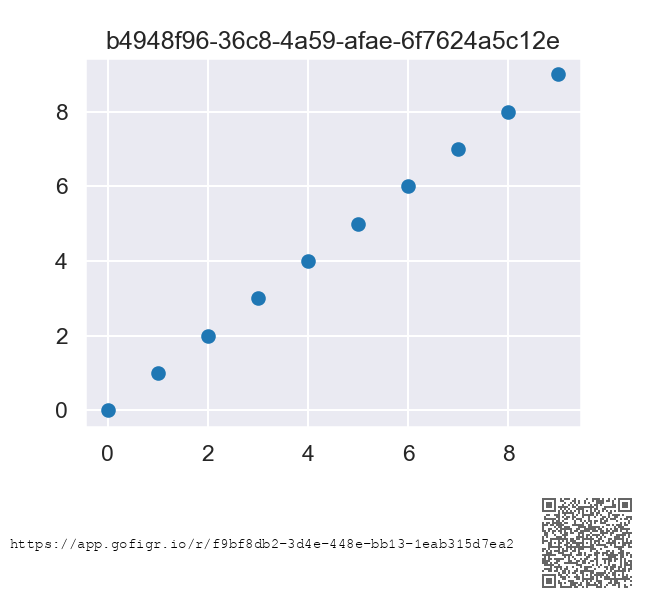


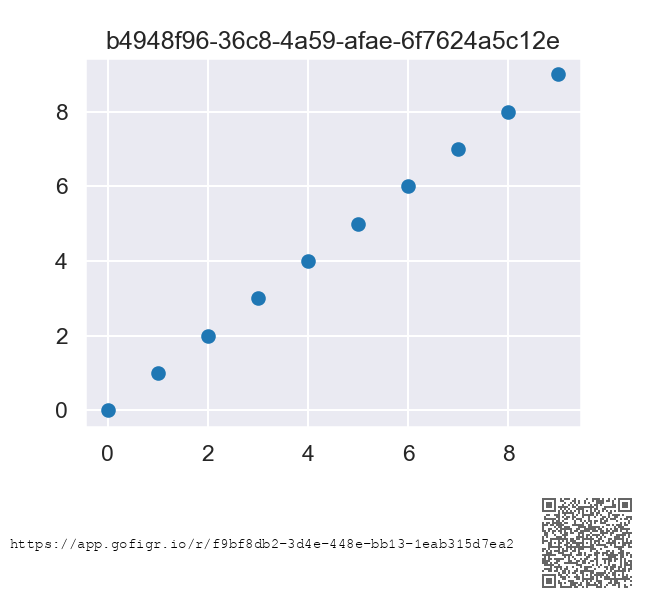
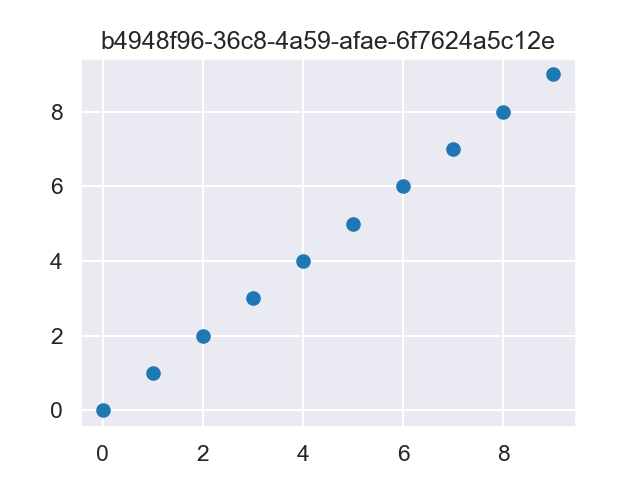
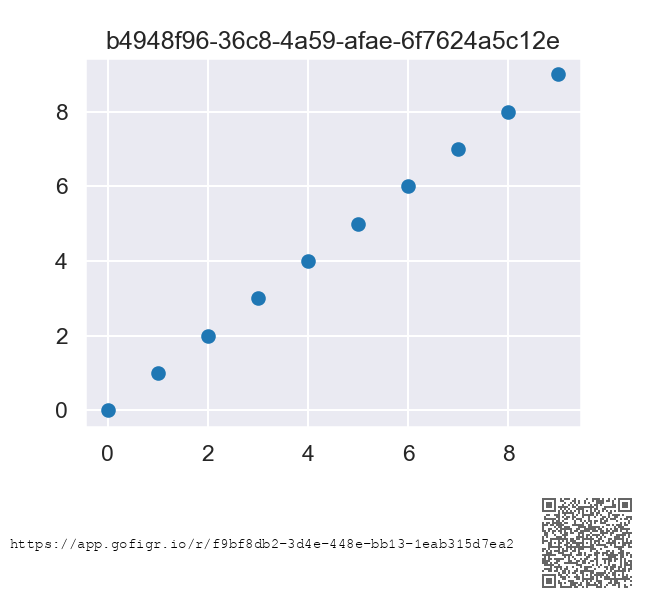
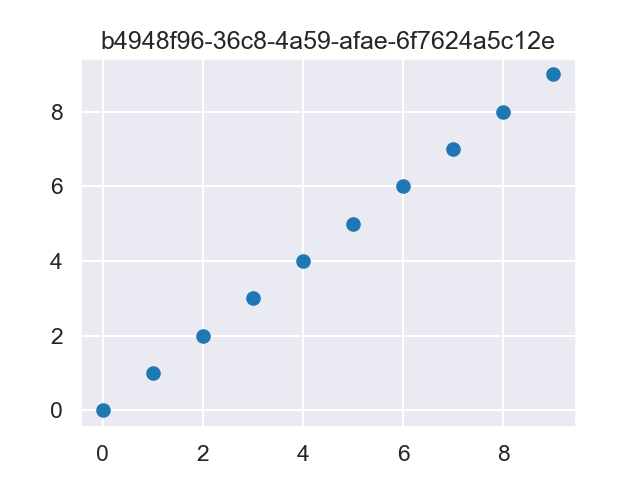

In [5]:
%load_ext gofigr

sns.set_style("darkgrid")
sns.set_context("talk") 

gf = get_gofigr()

# Try plotting in the same cell as configure(). auto_publish will break, but we should at least
# get a warning
fig_title1 = str(uuid4())
plt.figure()
plt.scatter(range(10), range(10))
plt.title(fig_title1)

In [6]:
TEST_RESULTS.append(check_figure("MPL: Configure and publish in one cell", fig_title1))
sync()

# MPL: Anonymous figure

Your figure doesn't have a title and will be published as 'Anonymous Figure'. To avoid this warning, set a figure title or manually call publish() with a target figure. See https://gofigr.io/docs/gofigr-python/latest/start.html#publishing-your-first-figure for an example.


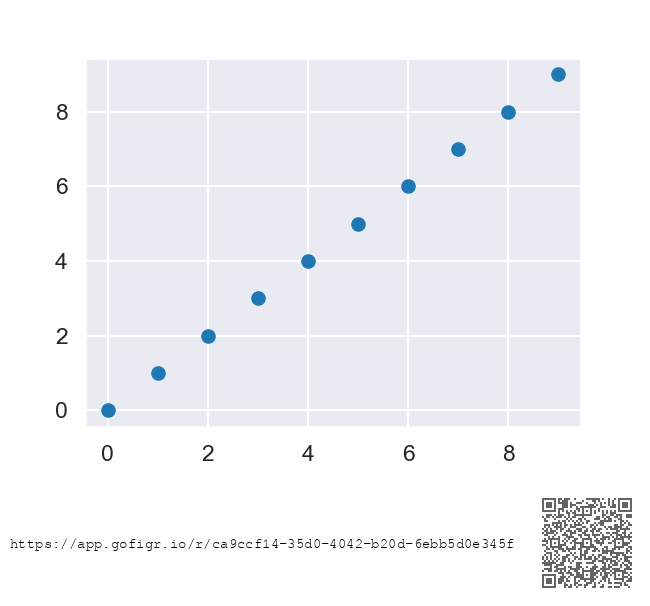


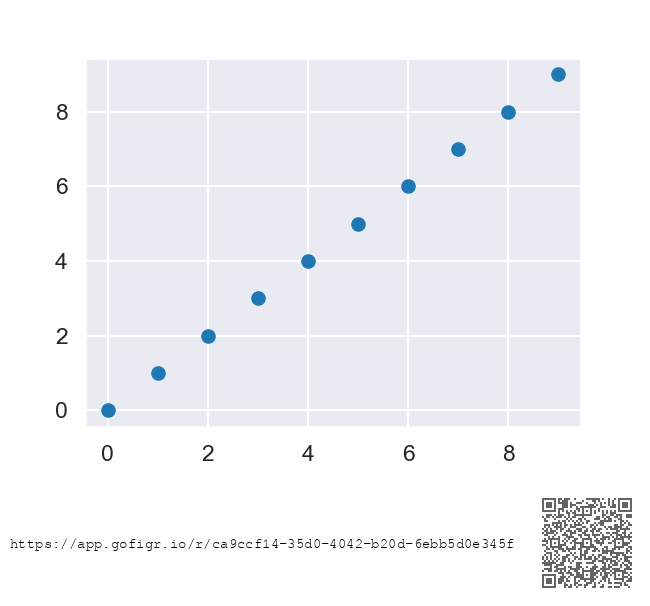
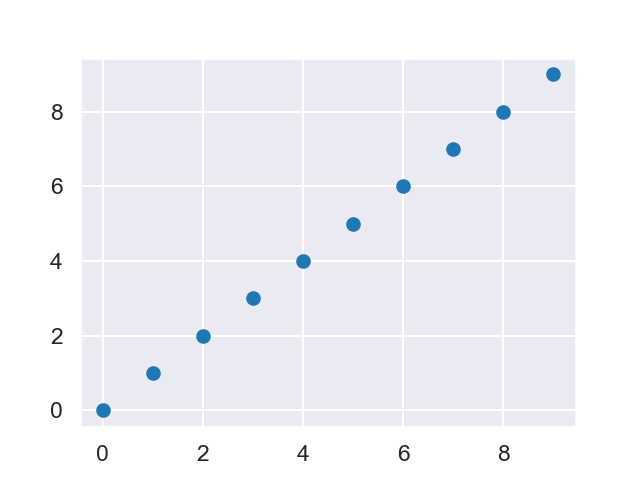
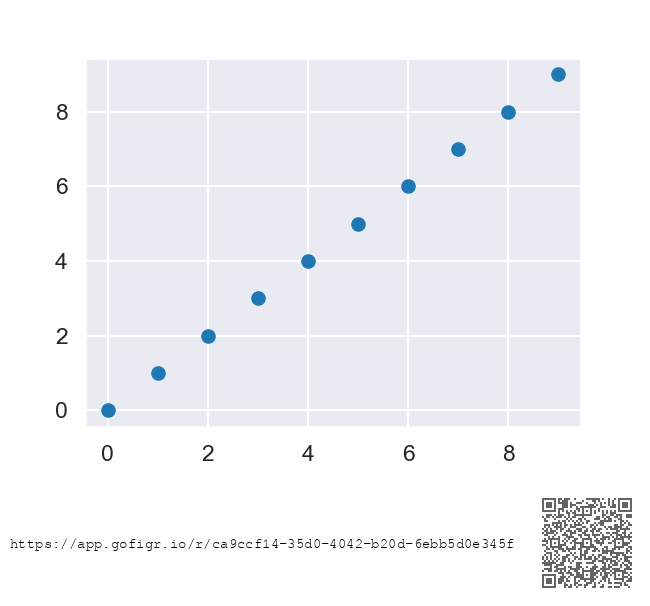
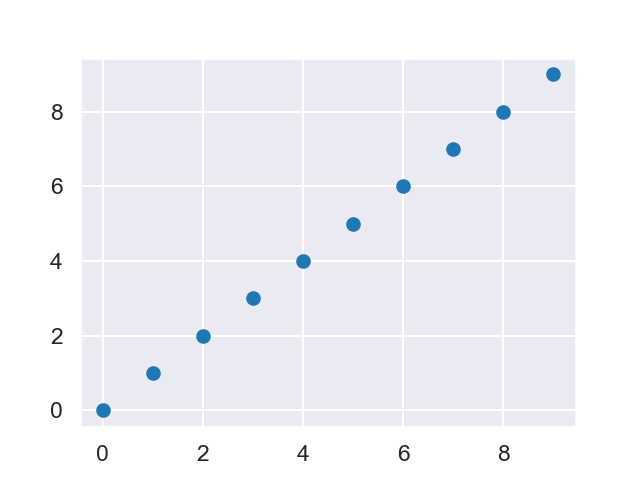

In [4]:
plt.scatter(x=range(10), y=range(10))

In [5]:
TEST_RESULTS.append(check_figure("MPL: Anonymous figure", "Anonymous Figure"))
sync()

object of type 'NoneType' has no len()


# MPL: Manual call to publish

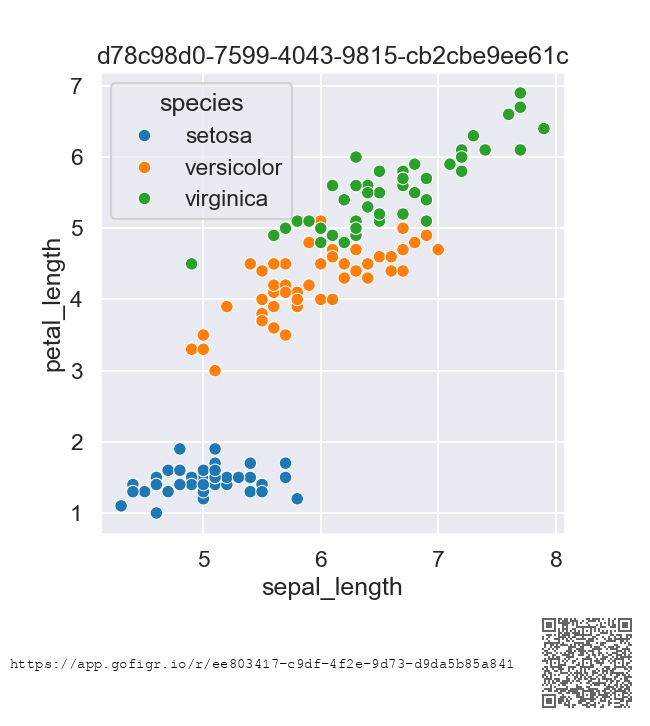


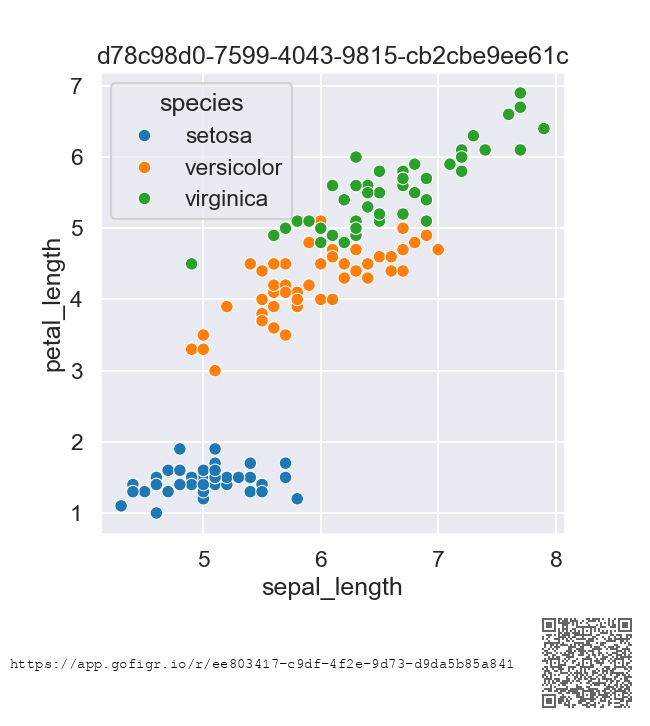
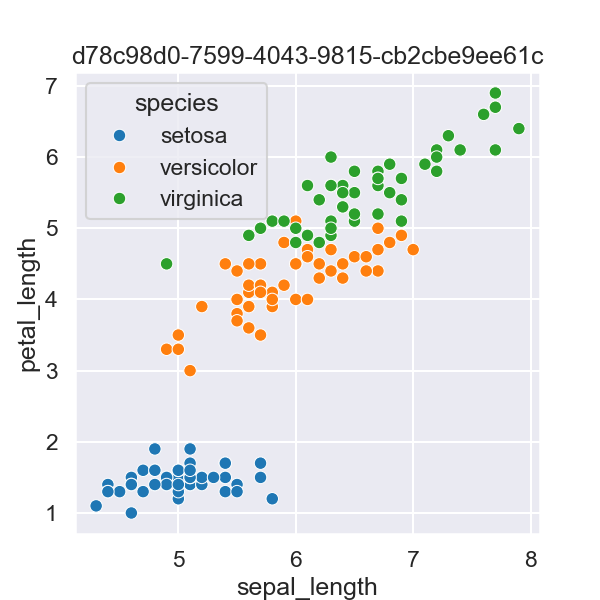
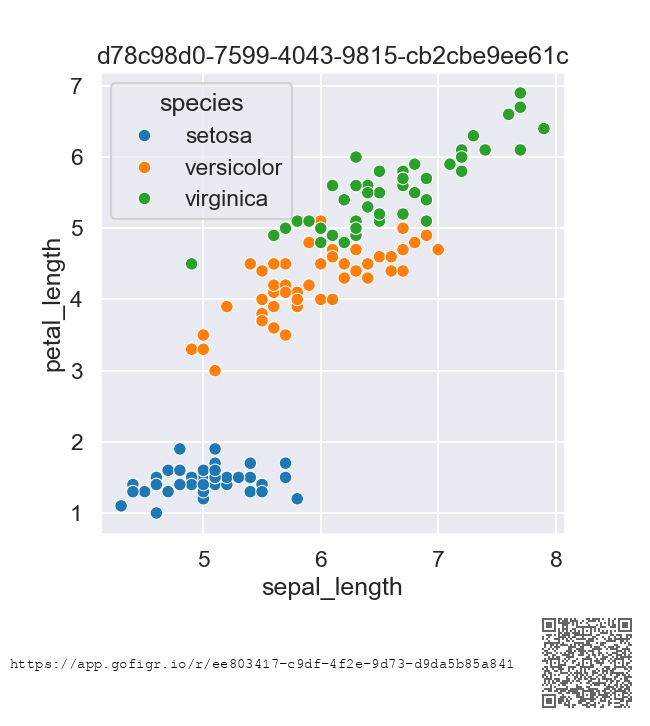
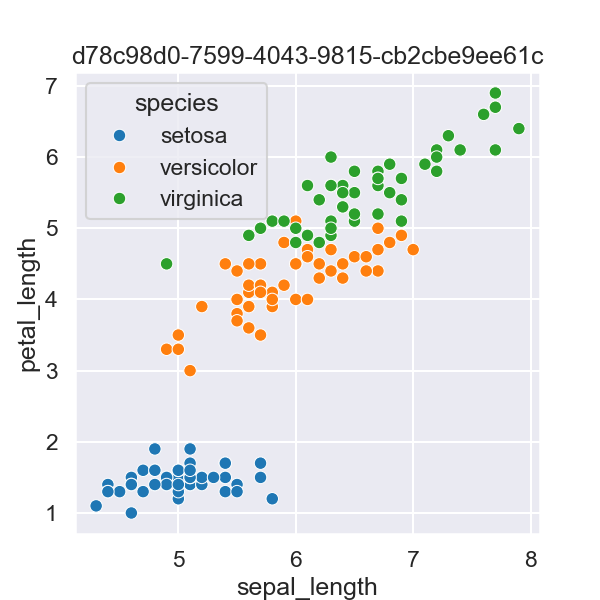

{'api_id': 'ee803417-c9df-4f2e-9d73-d9da5b85a841', 'revision_index': 0, 'size_bytes': 396720, 'metadata': {'notebook_path': '/Users/maciej/dev/gofigr-python/tests/integration/integration_tests.ipynb', 'notebook_name': 'tests/integration/integration_tests.ipynb', 'url': 'http://localhost:8888/lab/tree/tests/integration/integration_tests.ipynb', 'kernel': '/Users/maciej/dev/gofigr-demos/venv/bin/python', 'python_version': '3.11.12 (main, Apr  8 2025, 14:15:29) [Clang 16.0.0 (clang-1600.0.26.6)]', 'cell_id': '5d401c8e-d50e-40e7-8a70-a99f6db4e227', 'backend': 'matplotlib', 'git': {'branch': 'develop', 'hash': '50fe47018adeb1d3ee8d64ff5a874cd34984f213', 'remote_url': 'git@github.com:GoFigr/gofigr-python.git', 'commit_link': 'https://github.com/GoFigr/gofigr-python/commit/50fe47018adeb1d3ee8d64ff5a874cd34984f213'}}, 'figure': '4cc34754-d86e-4e2b-b62d-1110f7ad9e68', 'assets': [{'use_type': 'indirect', 'figure_revision': 'ee803417-c9df-4f2e-9d73-d9da5b85a841', 'asset_revision': '23b1d47f-aa09-

In [6]:
iris = sns.load_dataset("iris")

title2 = str(uuid4())

plt.figure(figsize=(6, 6))
sns.scatterplot(data=iris, 
                x="sepal_length", 
                y="petal_length", 
                hue="species", 
                palette="tab10")
plt.title(title2)

publish(target=FindByName(title2, create=True),
        dataframes={"IRIS": iris})

In [7]:
TEST_RESULTS.append(check_figure("MPL: Manual publish", title2))
sync()

object of type 'NoneType' has no len()


# MPL: Auto publish

Text(0.5, 1.0, '987c1460-e468-4ef5-b427-3329d413dd4e')

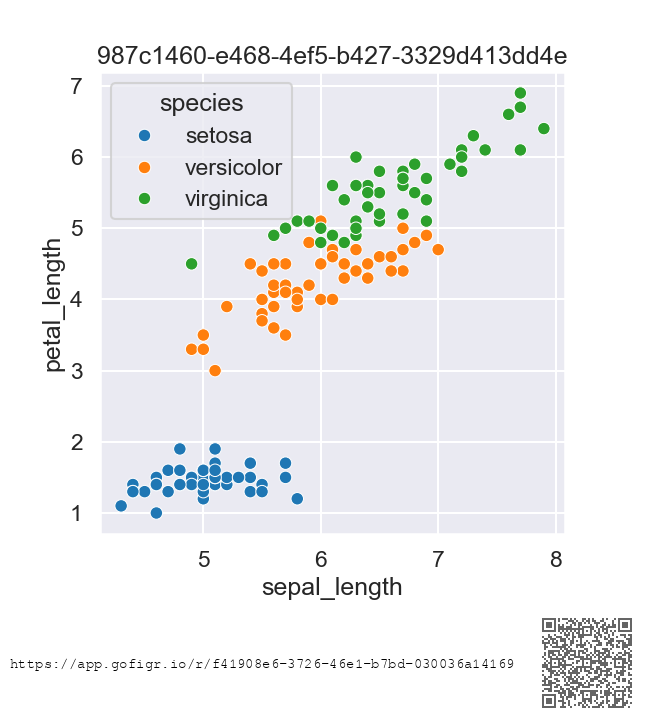

Error in callback <function flush_figures at 0x147ced4e0> (for post_execute):


KeyboardInterrupt: 

In [8]:
iris = sns.load_dataset("iris")

title3 = str(uuid4())
plt.figure(figsize=(6, 6))
sns.scatterplot(data=iris, 
                x="sepal_length", 
                y="petal_length", 
                hue="species", 
                palette="tab10")
plt.title(title3)

In [9]:
TEST_RESULTS.append(check_figure("MPL: Auto publish", title3))
sync()

object of type 'NoneType' has no len()


# MPL: Add revision

Text(0.5, 1.0, '987c1460-e468-4ef5-b427-3329d413dd4e')

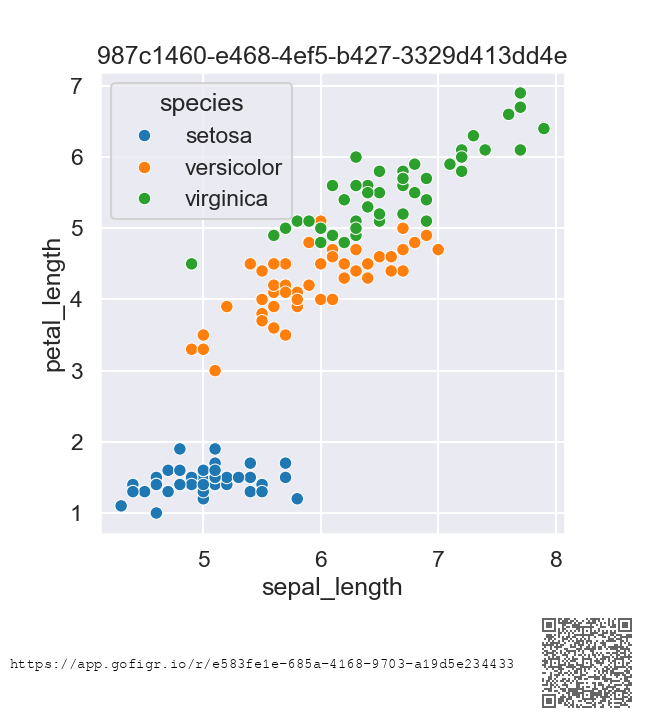


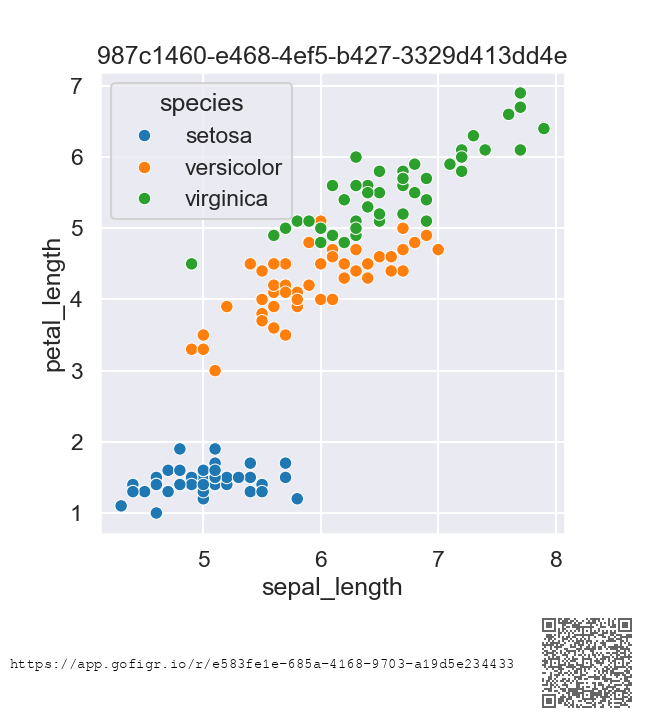
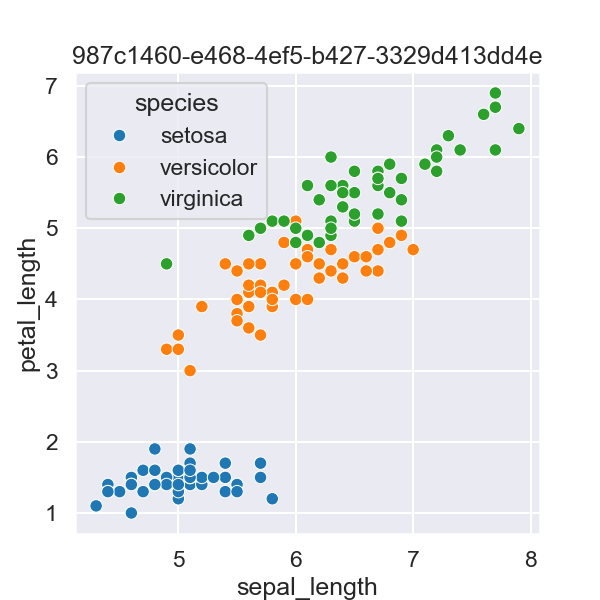
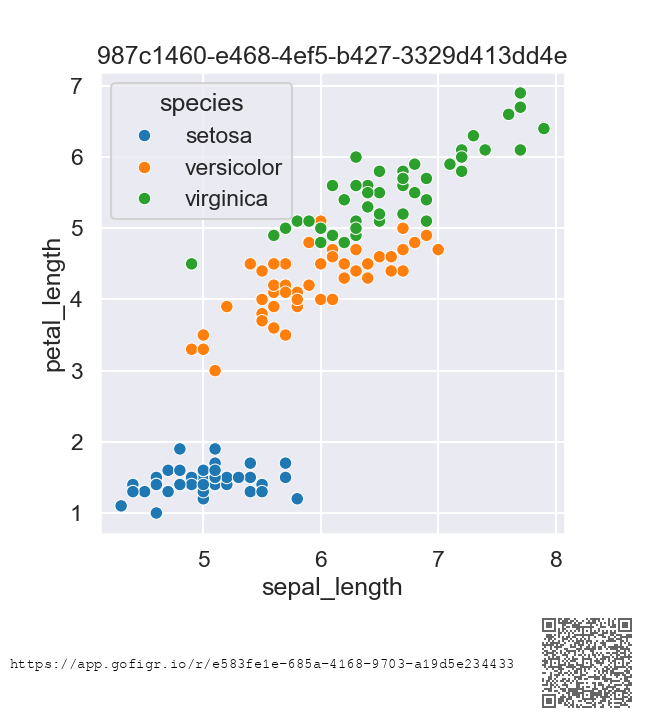
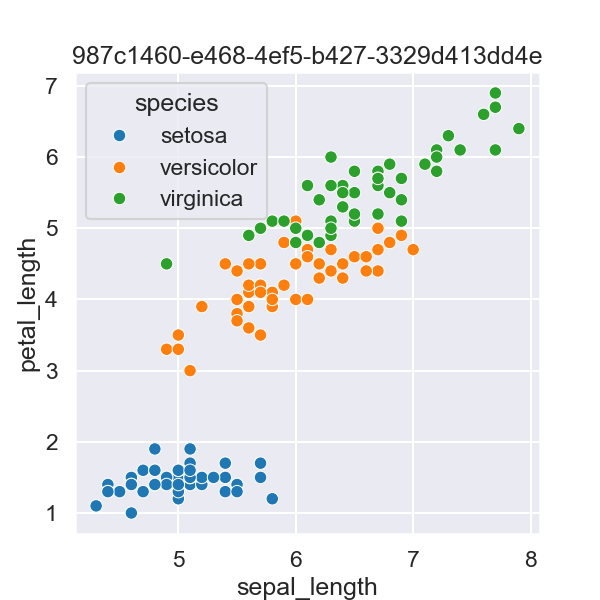

In [10]:
# Add a new revision to the same figure
plt.figure(figsize=(6, 6))
sns.scatterplot(data=iris, 
                x="sepal_length", 
                y="petal_length", 
                hue="species", 
                palette="tab10")
plt.title(title3)

In [11]:
TEST_RESULTS.append(check_figure("MPL: Auto-publish second revision", title3,
                                expected_revisions=2))
sync()

object of type 'NoneType' has no len()


# MPL: Inline backend

Text(0.5, 1.0, '39196c48-1cb1-4a35-9df4-8b890601e6b7')

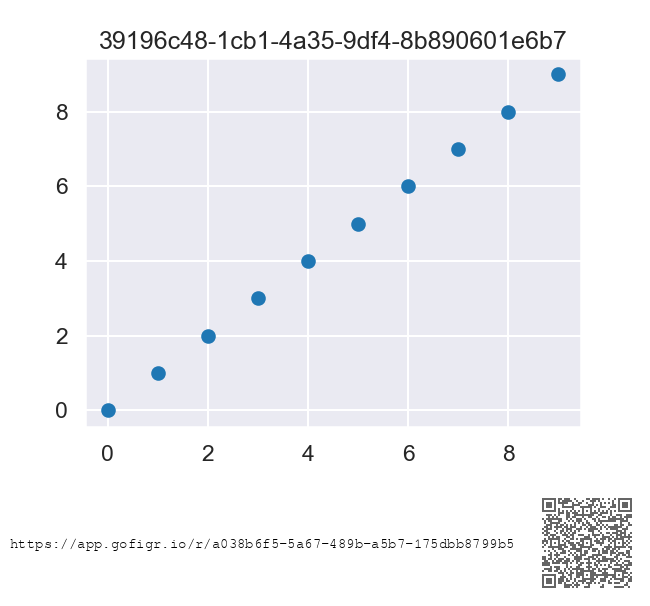


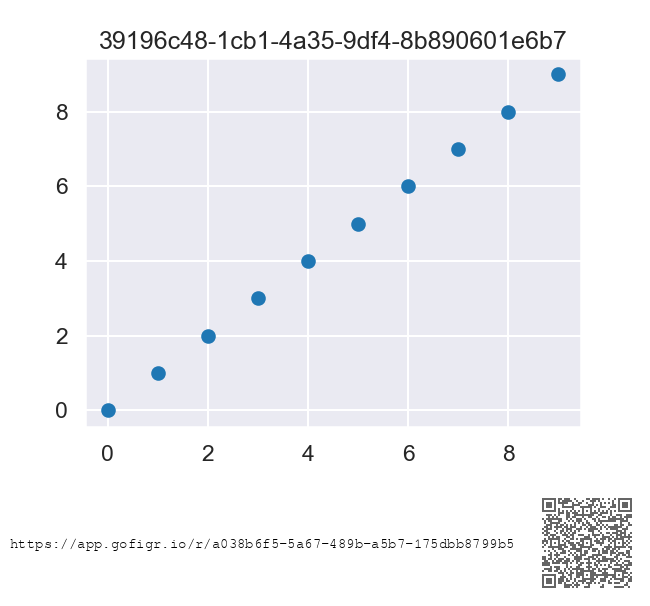
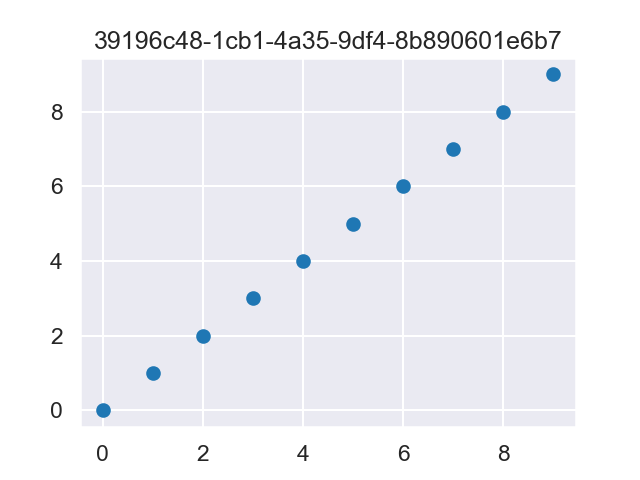
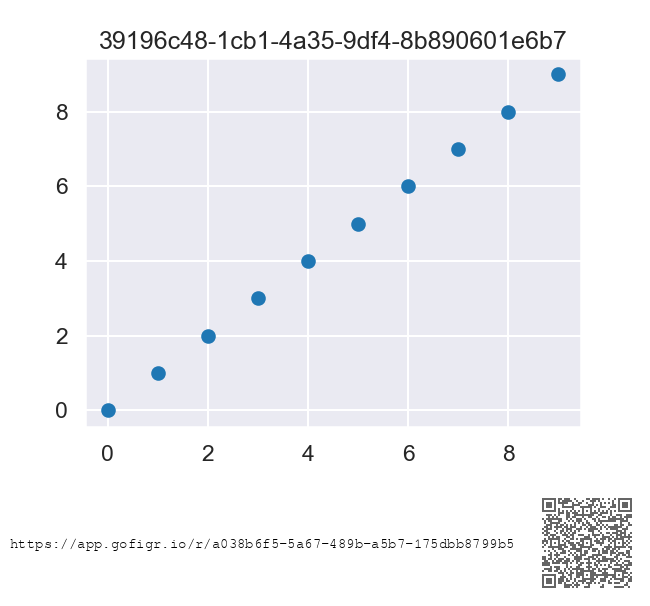
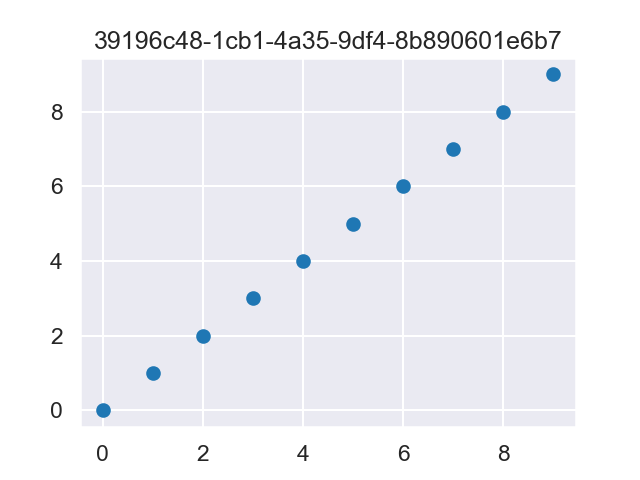

In [12]:
%matplotlib inline
%config InlineBackend.figure_format="retina"

title4 = str(uuid4())
plt.figure()
plt.scatter(range(10), range(10))
plt.title(title4)

In [13]:
TEST_RESULTS.append(check_figure("MPL: inline backend", title4))
sync()

object of type 'NoneType' has no len()


# MPL: Mix-and-match manual and auto publish

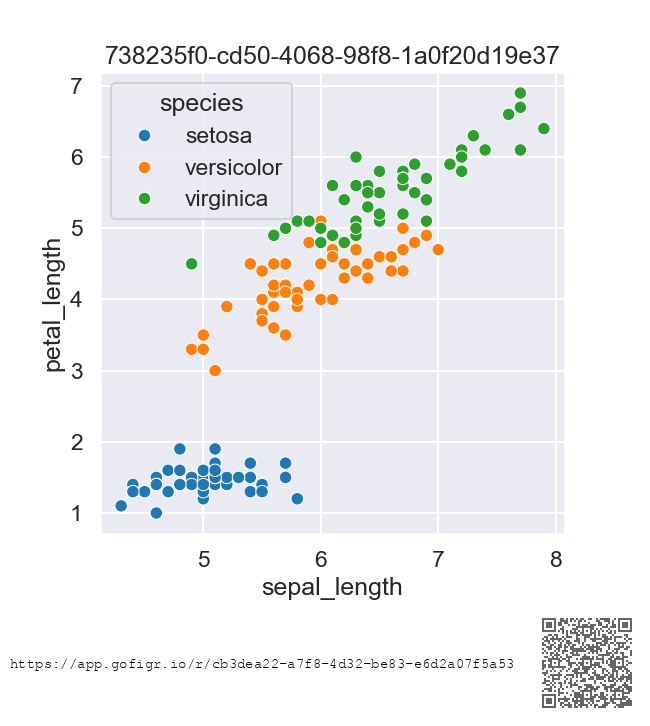


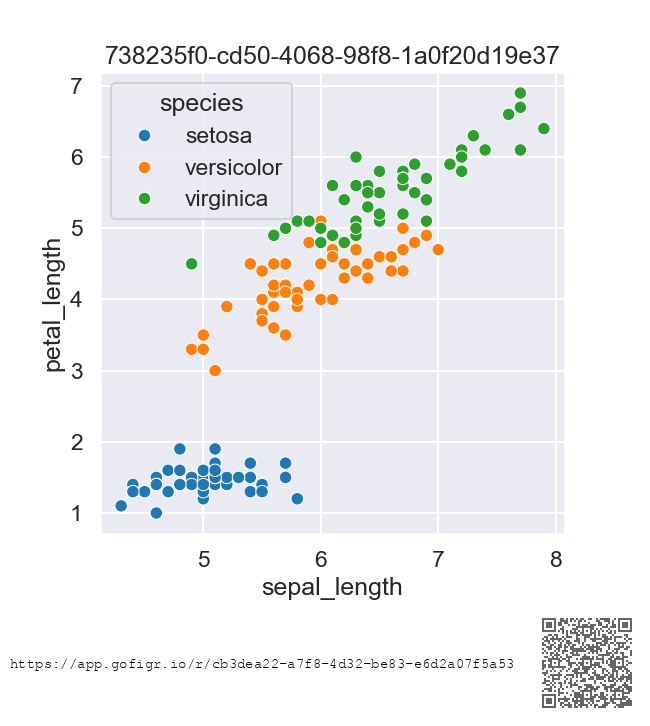
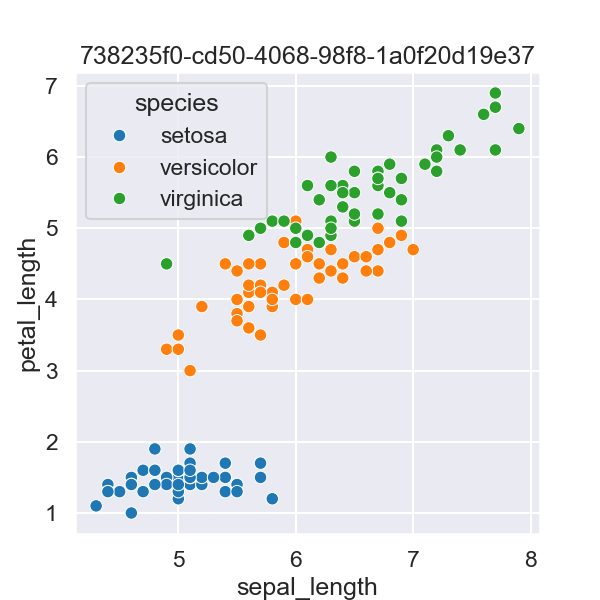
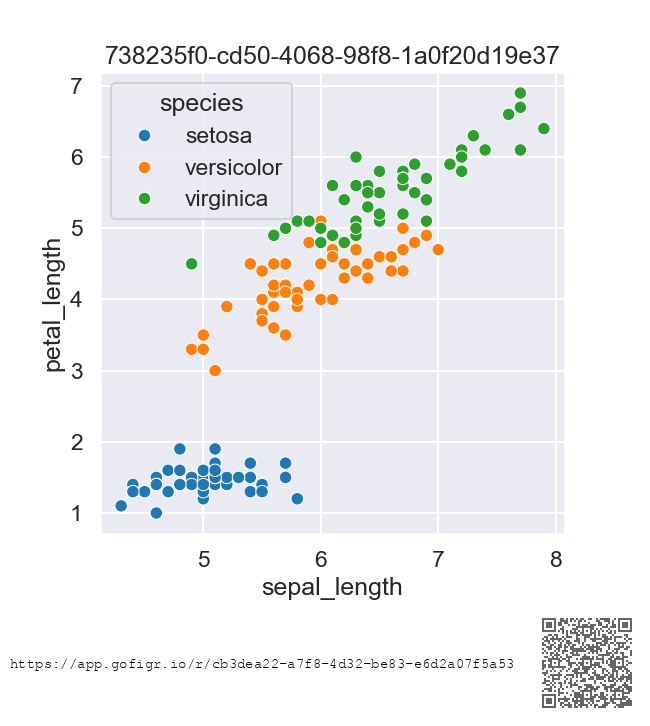
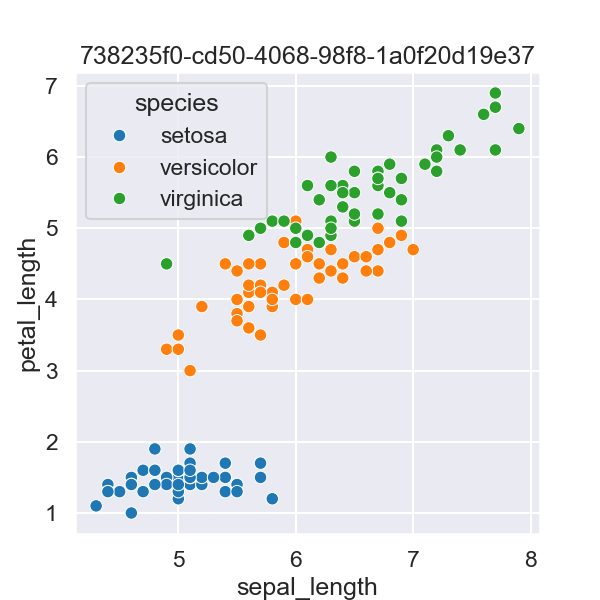

Text(0.5, 1.0, '738235f0-cd50-4068-98f8-1a0f20d19e37')

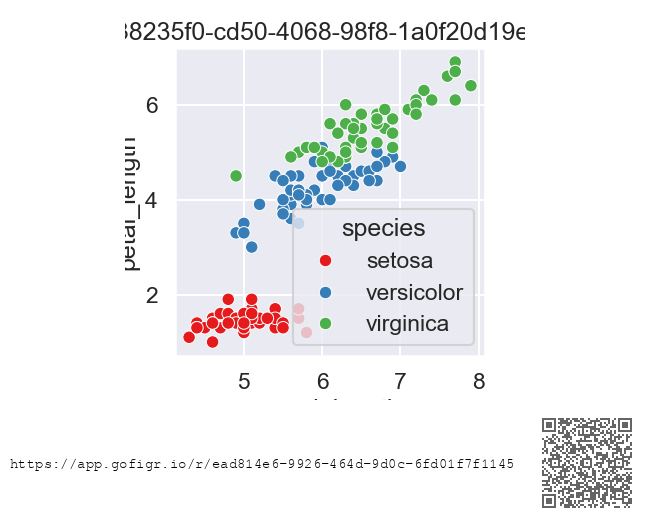


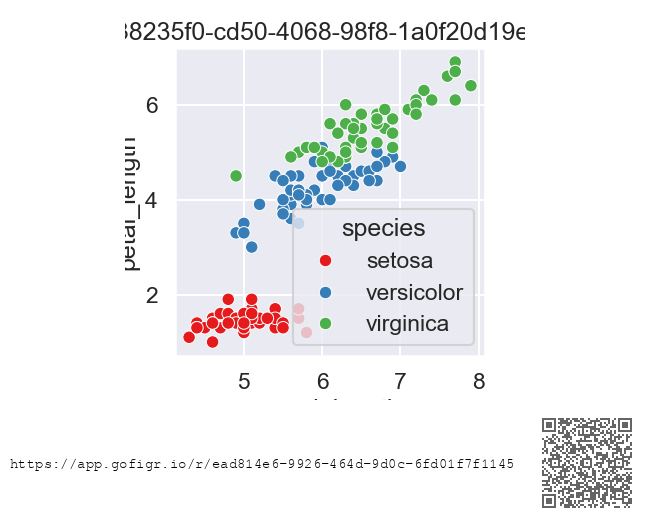
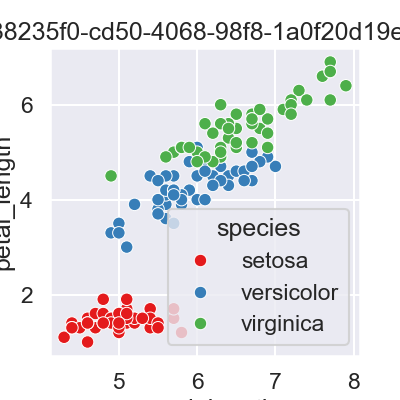
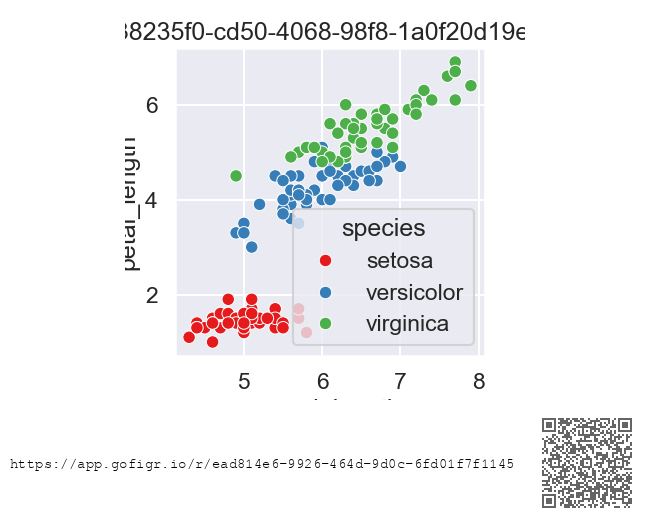
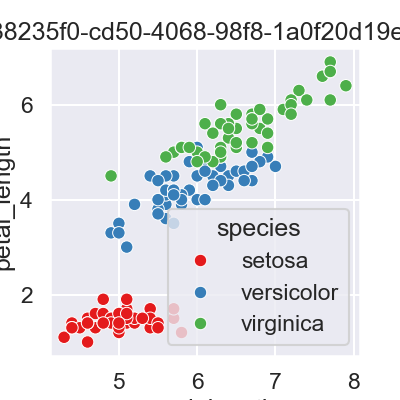

In [14]:
title5 = str(uuid4())
plt.figure(figsize=(6, 6))
sns.scatterplot(data=iris, 
                x="sepal_length", 
                y="petal_length", 
                hue="species", 
                palette="tab10")
plt.title(title5)
publish()

plt.figure(figsize=(4, 4))
sns.scatterplot(data=iris, 
                x="sepal_length", 
                y="petal_length", 
                hue="species", 
                palette="Set1")
plt.title(title5)

In [15]:
TEST_RESULTS.append(check_figure("MPL: Mix manual and auto-publish", title5, expected_revisions=2))
sync()

object of type 'NoneType' has no len()


# MPL: Subplots

Text(0.5, 0.98, 'dd8e713f-7db3-43d4-aa61-c1733b4100c1')

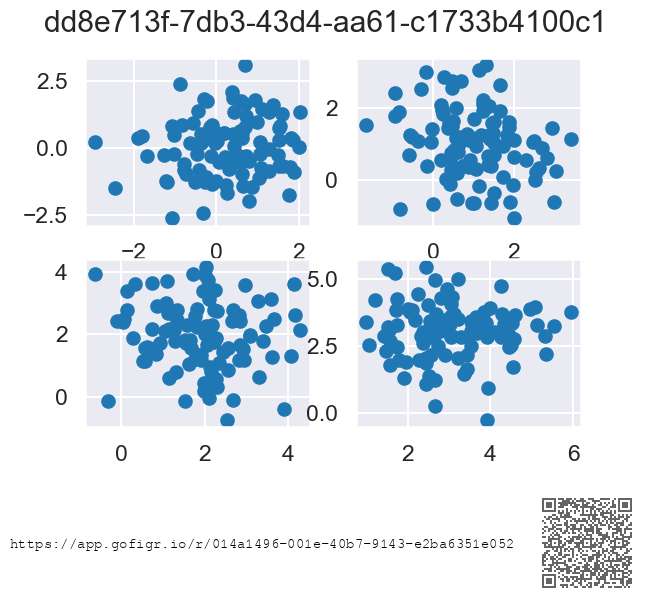


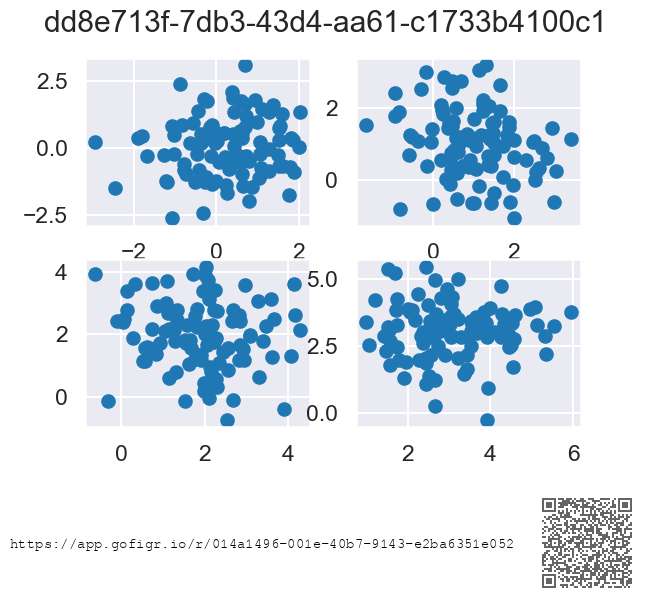
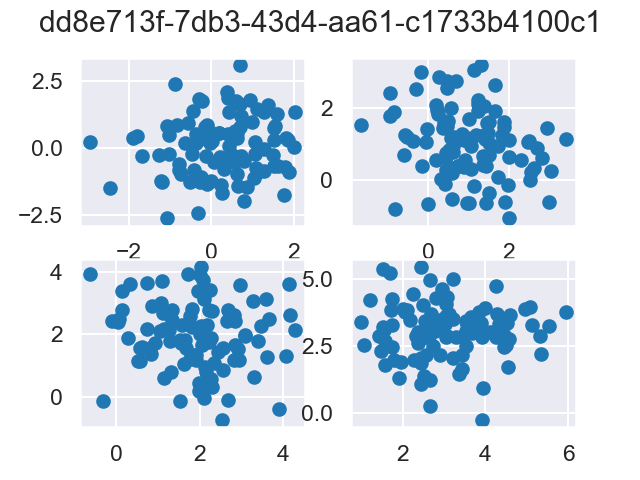
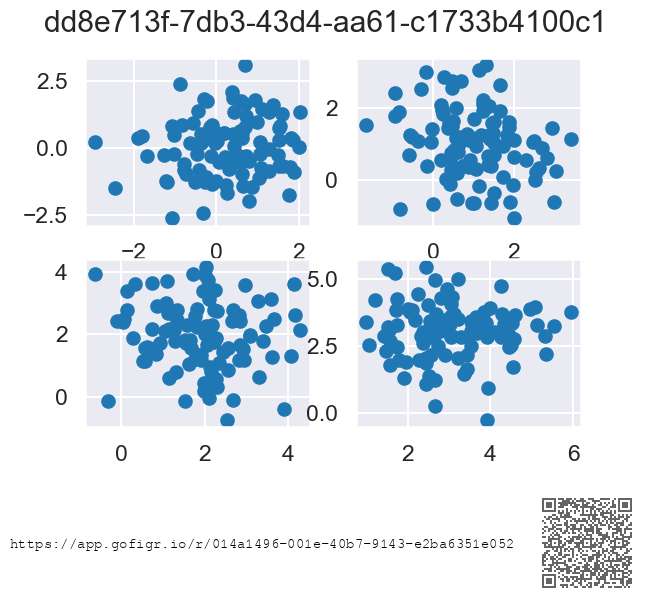
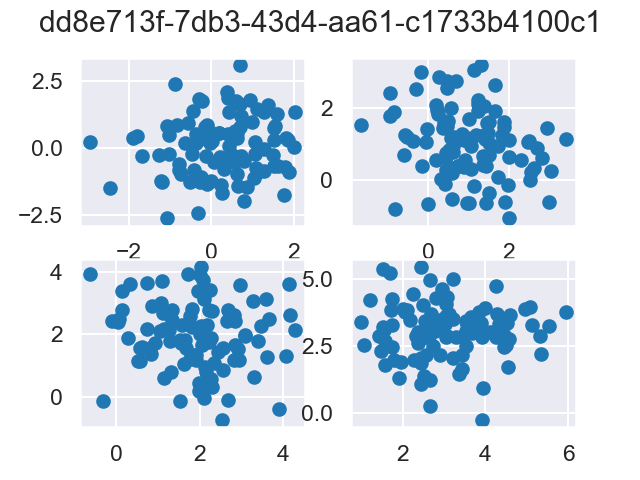

In [16]:
import numpy as np

title6 = str(uuid4())
fig, ax = plt.subplots(nrows=2, ncols=2)
ax = np.ravel(ax)

for idx, axis in enumerate(ax):
    axis.scatter(x=np.random.normal(loc=idx, size=100), y=np.random.normal(loc=idx, size=100))

fig.suptitle(title6)

In [17]:
TEST_RESULTS.append(check_figure("MPL: Subplots", title6, expected_revisions=1))
sync()

object of type 'NoneType' has no len()


# Plotly

## Static figure

In [18]:
import plotly
plotly.io.kaleido.scope.default_width = 800
plotly.io.kaleido.scope.default_height = 600


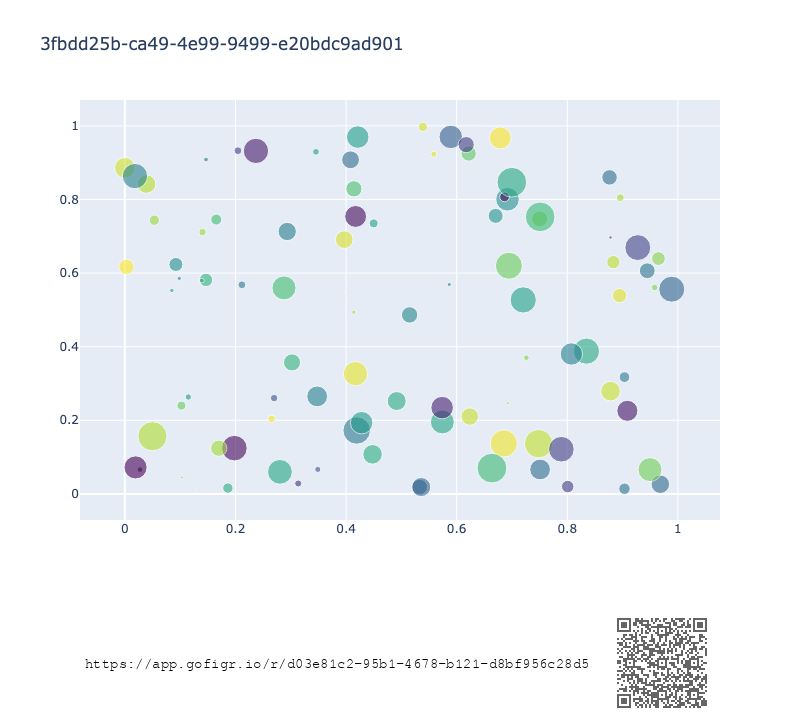
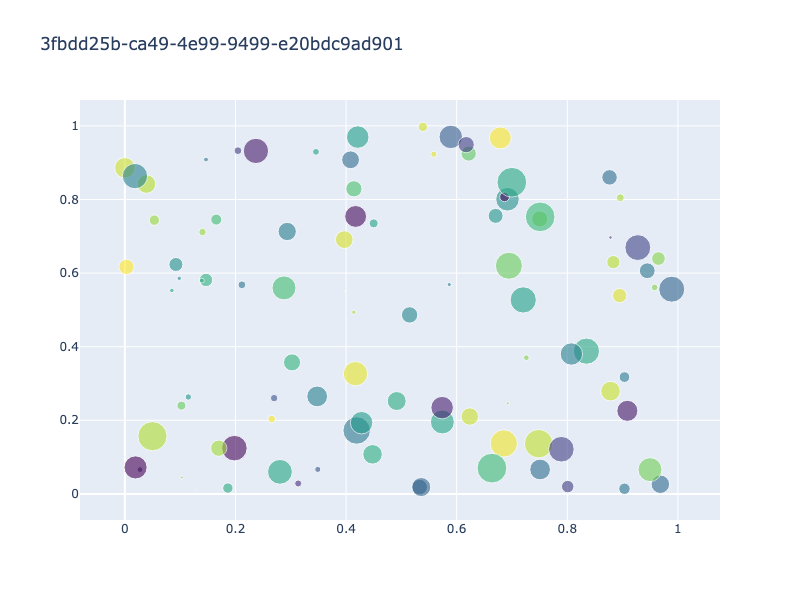
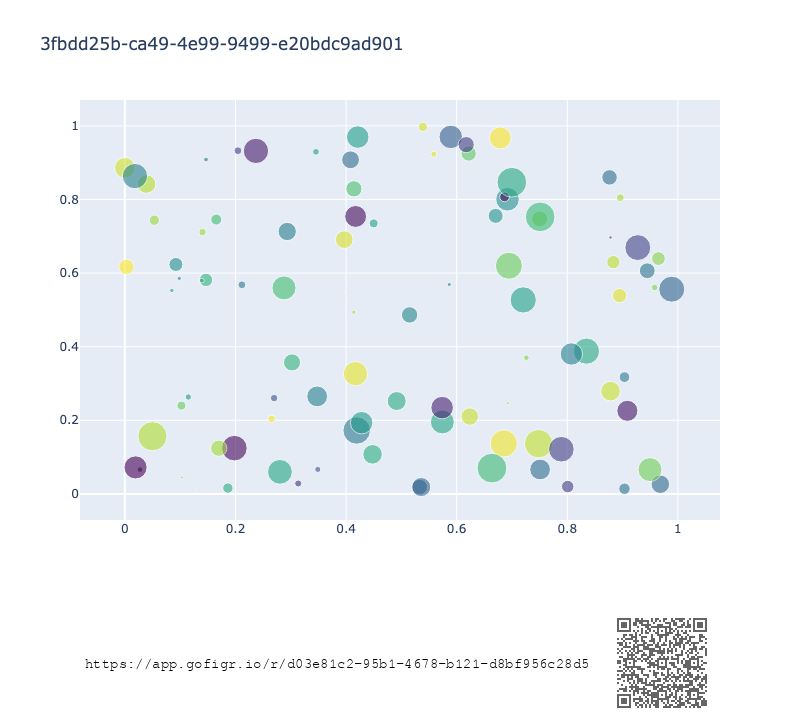
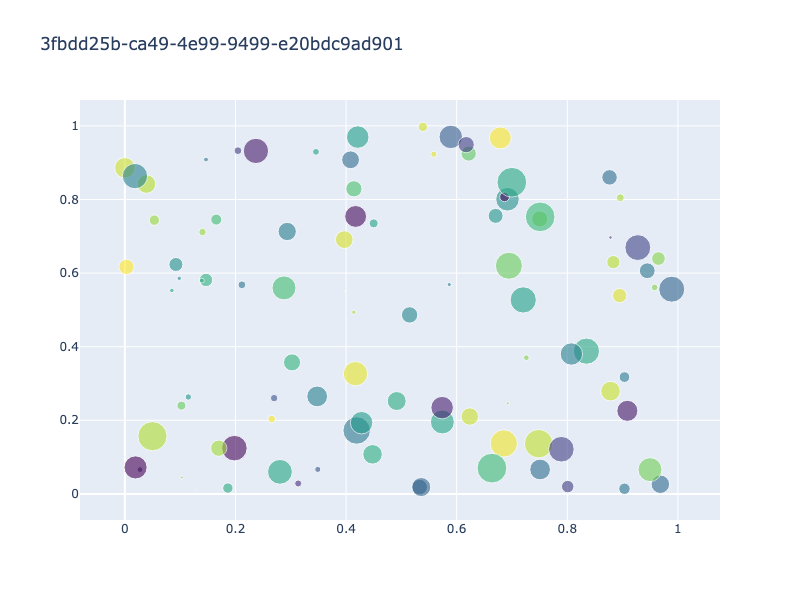


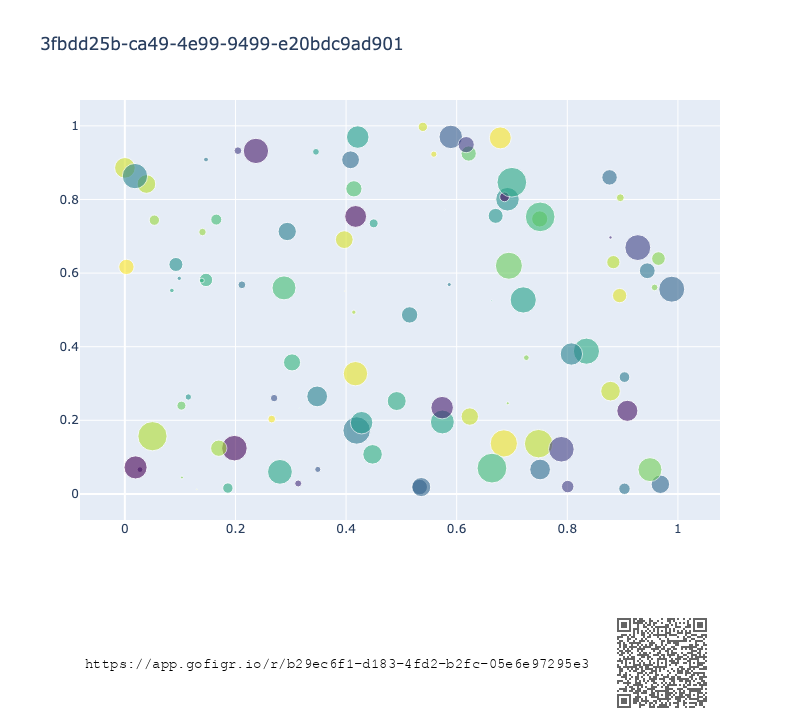
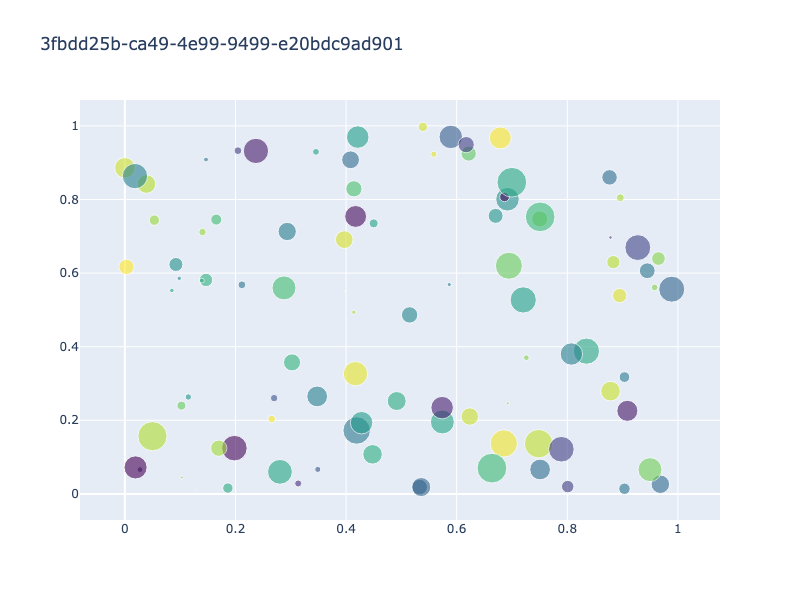
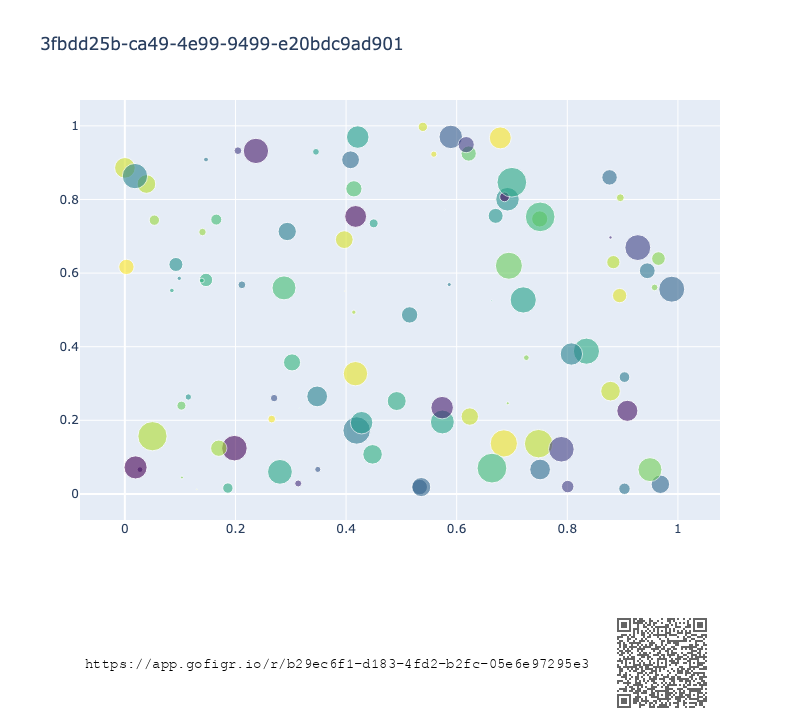
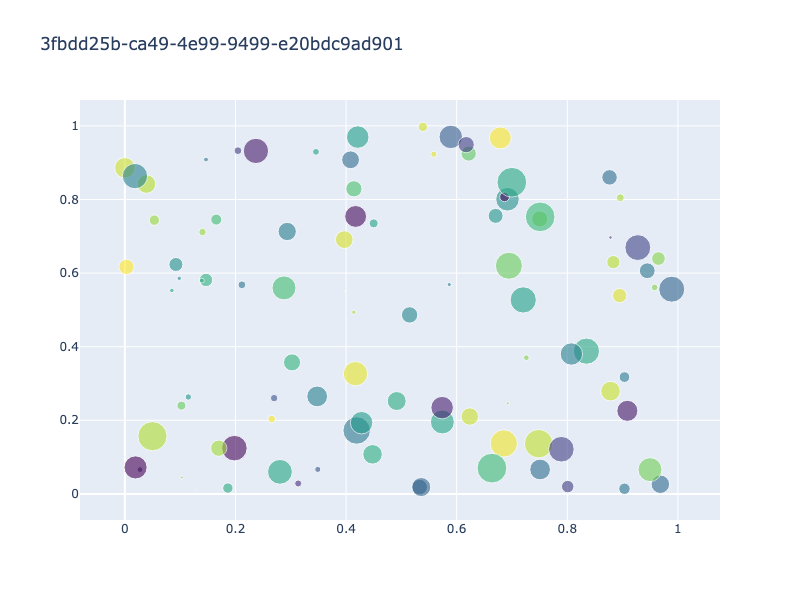


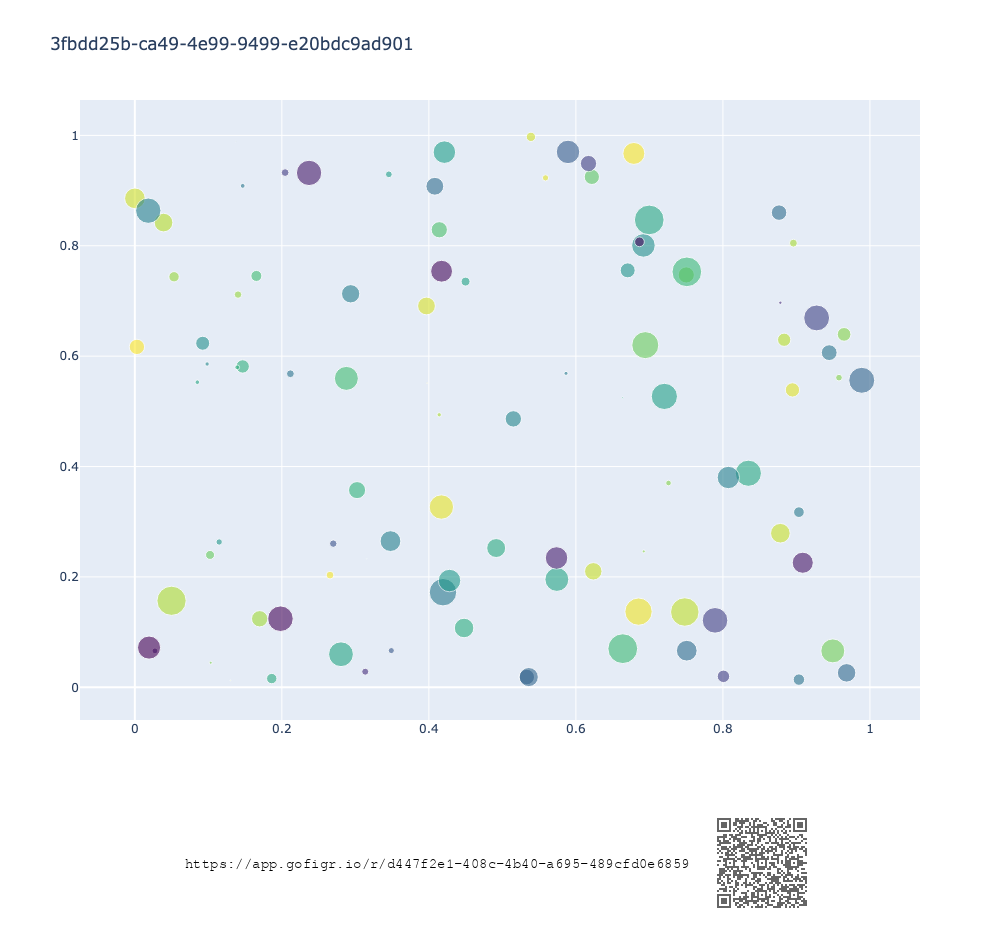
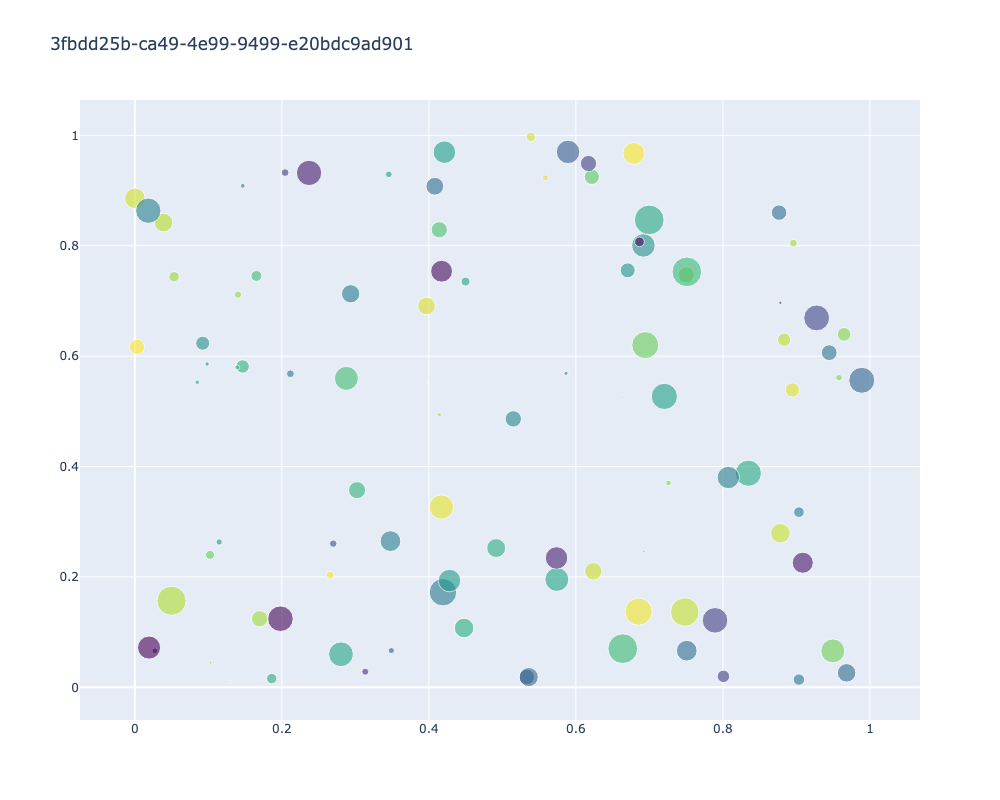
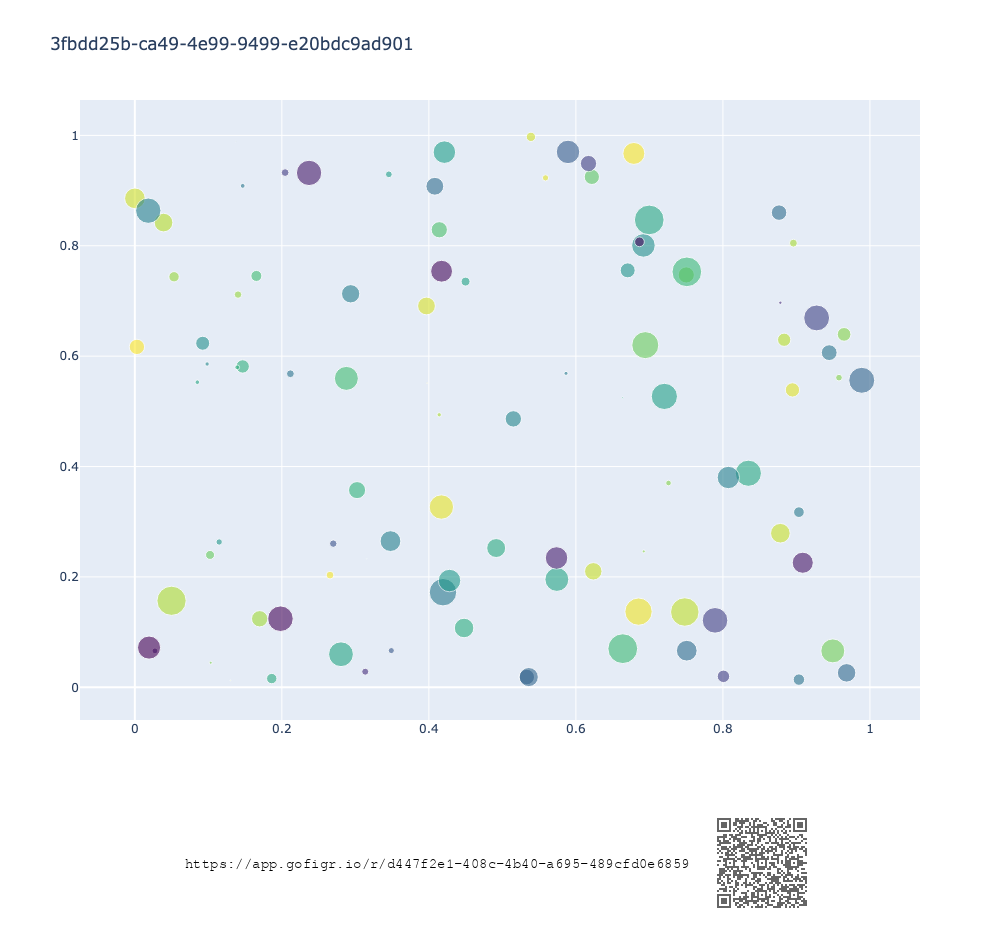
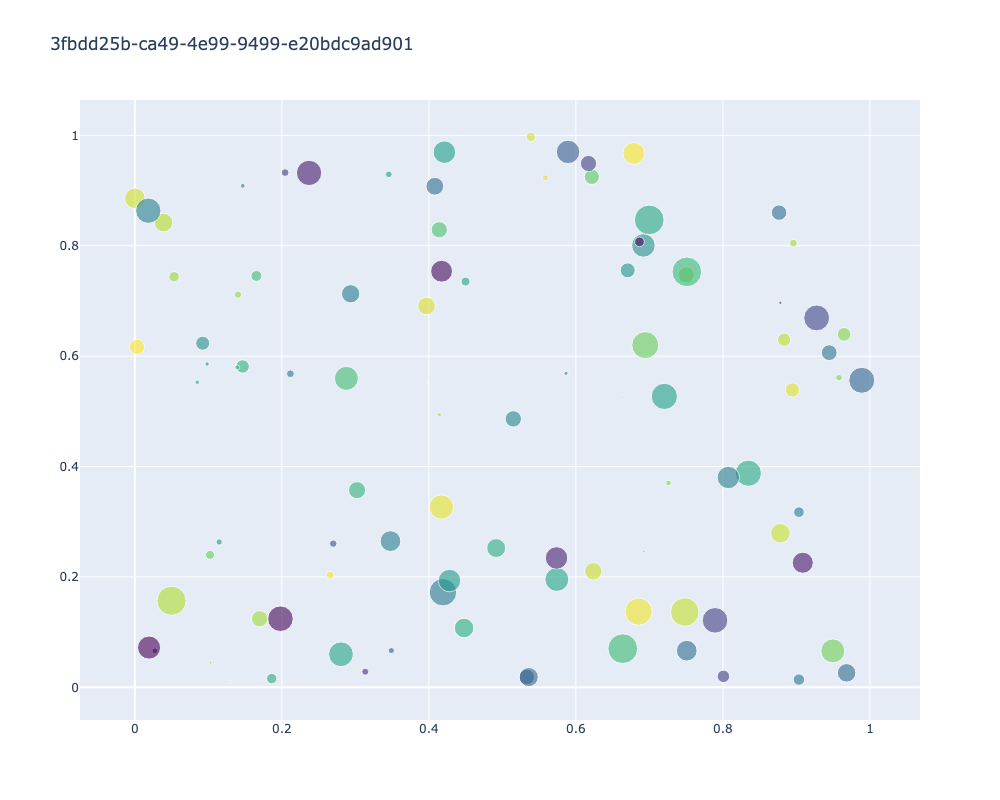

{'api_id': 'd447f2e1-408c-4b40-a695-489cfd0e6859', 'revision_index': 2, 'size_bytes': 239789, 'metadata': {'notebook_path': '/Users/maciej/dev/gofigr-python/tests/integration/integration_tests.ipynb', 'notebook_name': 'tests/integration/integration_tests.ipynb', 'url': 'http://localhost:8888/lab/tree/tests/integration/integration_tests.ipynb', 'kernel': '/Users/maciej/dev/gofigr-demos/venv/bin/python', 'python_version': '3.11.12 (main, Apr  8 2025, 14:15:29) [Clang 16.0.0 (clang-1600.0.26.6)]', 'cell_id': 'd6b3bd68', 'backend': 'plotly', 'git': {'branch': 'develop', 'hash': '50fe47018adeb1d3ee8d64ff5a874cd34984f213', 'remote_url': 'git@github.com:GoFigr/gofigr-python.git', 'commit_link': 'https://github.com/GoFigr/gofigr-python/commit/50fe47018adeb1d3ee8d64ff5a874cd34984f213'}}, 'figure': '755b182c-a353-4e33-bc97-643714979db5', 'assets': [{'use_type': 'indirect', 'figure_revision': 'd447f2e1-408c-4b40-a695-489cfd0e6859', 'asset_revision': '23b1d47f-aa09-4e10-a1de-32d25469405a'}, {'use_

In [19]:
import plotly.graph_objects as go
import numpy as np
np.random.seed(1)

title7 = str(uuid4())

N = 100
x = np.random.rand(N)
y = np.random.rand(N)
colors = np.random.rand(N)
sz = np.random.rand(N) * 30

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=x,
    y=y,
    mode="markers",
    marker=go.scatter.Marker(
        size=sz,
        color=colors,
        opacity=0.6,
        colorscale="Viridis"
    )))
fig.update_layout(title=title7)

fig.show()

publish(fig=fig, image_options={'width': 800, 'height': 600})
publish(fig=fig, image_options={'width': 1000, 'height': 800})

In [20]:
TEST_RESULTS.append(check_figure("Plotly - manual publish", title7, expected_revisions=3))
sync()

object of type 'NoneType' has no len()


## Plotly -- autopublish

/Users/maciej/dev/gofigr-demos/venv/lib/python3.11/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.




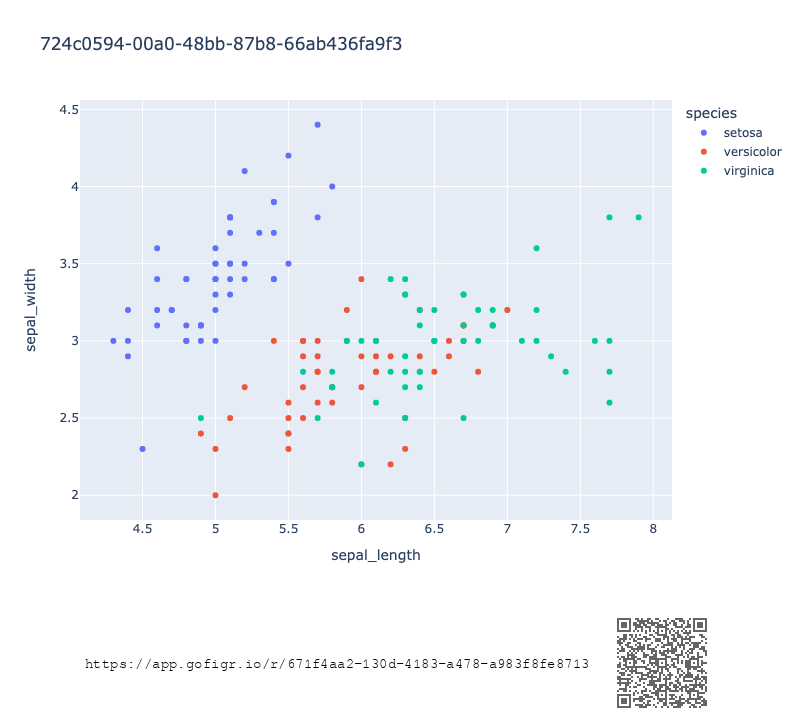
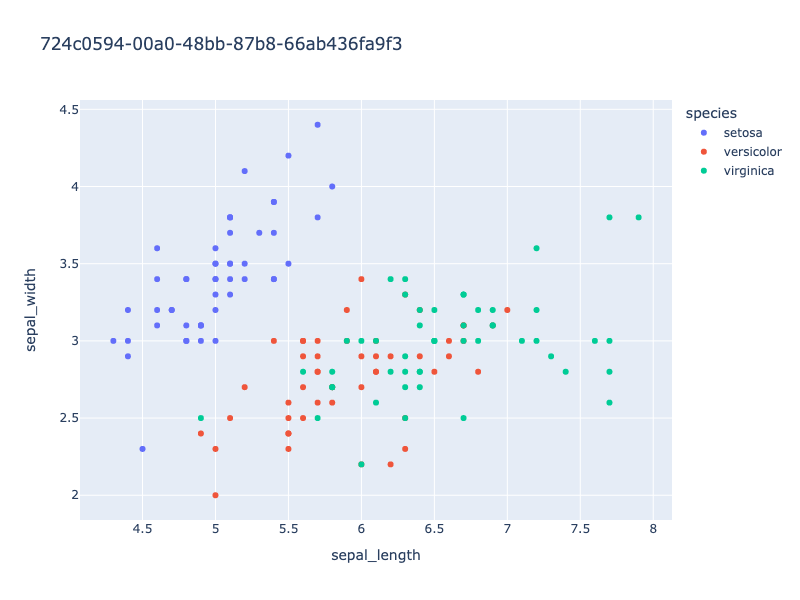
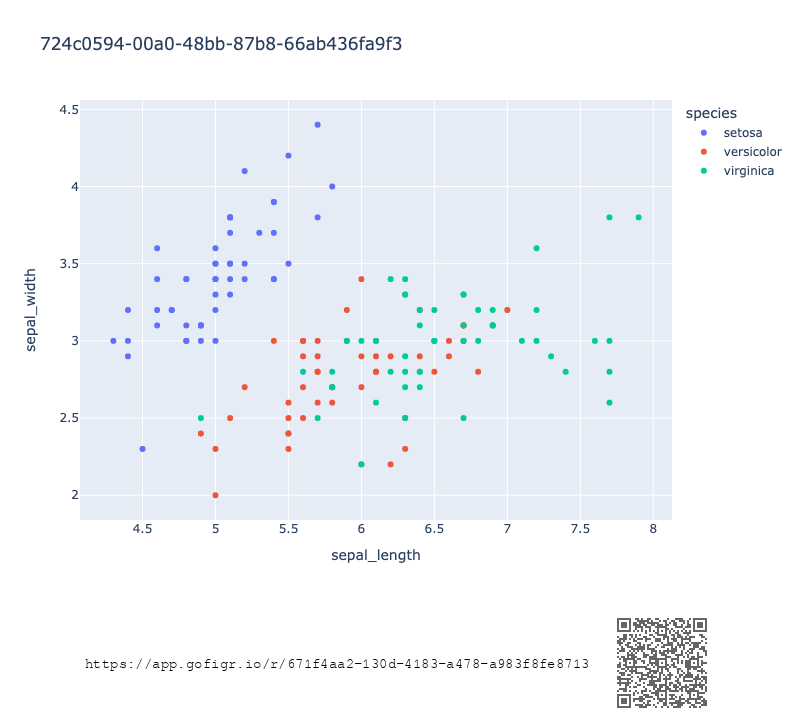
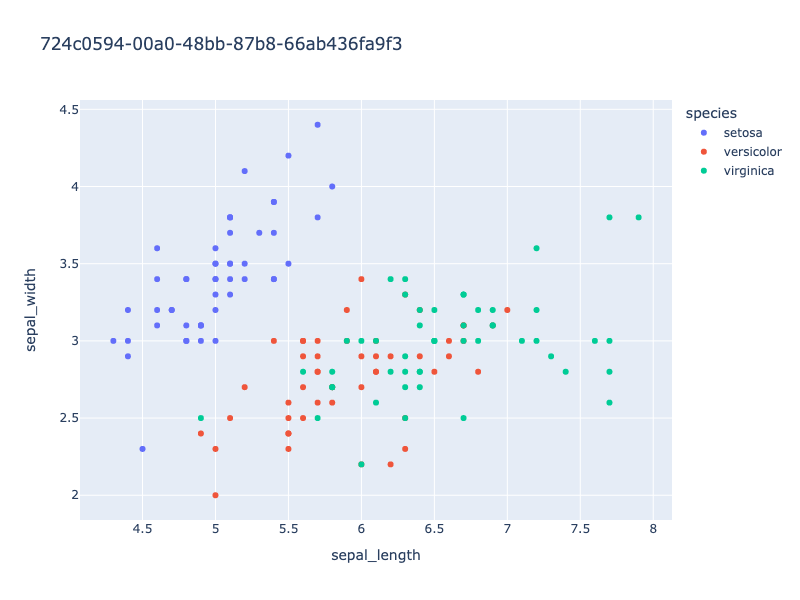

In [21]:
import plotly.express as px

title8 = str(uuid4())
df = px.data.iris()
fig = px.scatter(df, x="sepal_length", y="sepal_width", color="species",
                title=title8)
fig.show()

In [22]:
TEST_RESULTS.append(check_figure("Plotly - autopublish", title8, expected_revisions=1))
sync()

object of type 'NoneType' has no len()


# Py3Dmol

In [23]:
title10 = str(uuid4())
p = None
if sys.version_info >= (3, 8):
    p = py3Dmol.view(query='mmtf:1ycr')
    p.setStyle({'cartoon': {'color':'spectrum'}})
    p.title = title10

p

KeyboardInterrupt: 

In [ ]:
TEST_RESULTS.append(check_figure("Py3Dmol - autopublish", title10, expected_revisions=1))
sync()

# Py3DMol -- call to show

In [ ]:
title10b = str(uuid4())
if sys.version_info >= (3, 8):
    p = py3Dmol.view(query='mmtf:1ycr', width=1920, height=200)
    p.setStyle({'cartoon': {'color':'spectrum'}})
    p.title = title10b
    p.show()

In [ ]:
TEST_RESULTS.append(check_figure("Py3Dmol - call to show()", title10b, expected_revisions=1))
sync()

# Py3Dmol -- manual publish

In [ ]:
title11 = str(uuid4())
if sys.version_info >= (3, 8):
    p = py3Dmol.view(query='mmtf:1ycr')
    p.setStyle({'cartoon': {'color':'spectrum'}})
    p.title = title11
    publish(p)

In [ ]:
TEST_RESULTS.append(check_figure("Py3Dmol - manual publish", title11, expected_revisions=1))
sync()

# Py3Dmol -- call to show and return view from cell

In [ ]:
title12 = str(uuid4())
p = None
if sys.version_info >= (3, 8):
    p = py3Dmol.view(query='mmtf:1ycr')
    p.setStyle({'cartoon': {'color':'spectrum'}})
    p.title = title12
    p.show()

p

In [ ]:
TEST_RESULTS.append(check_figure("Py3Dmol - call to show and return view from cell", title12, expected_revisions=1))
sync()

# plotnine - basic plot

In [ ]:
from plotnine import *
from plotnine.data import *

In [ ]:
title13 = str(uuid4())

fig = (
    ggplot(mtcars, aes("wt", "mpg", color="factor(gear)"))
    + geom_point()
    + stat_smooth(method="lm")
    + facet_wrap("gear")
    + ggtitle(title13)
)

fig

In [ ]:
TEST_RESULTS.append(check_figure("plotnine - basic figure", title13, expected_revisions=1))
sync()

# plotnine - facets

In [ ]:
meat_long = meat.melt(
    id_vars="date",
    value_vars=["beef", "veal", "pork", "lamb_and_mutton", "broilers", "turkey"],
    var_name="animal",
    value_name="weight"
).dropna()

meat_long.head()

In [ ]:
title14 = str(uuid4())

# Gallery, lines
def titled(strip_title):
    return " ".join(s.title() if s != "and" else s for s in strip_title.split("_"))

(
    ggplot(meat_long, aes("date", "weight", color="animal"))
    + geom_line(size=.5, show_legend=False)
    + facet_wrap("animal", labeller=titled)
    + scale_x_datetime(date_breaks="20 years", date_labels="%Y")
    + labs(
        x="Date",
        y="Weight (million pounds)",
        title=title14,
    )
    + theme_538(base_size=9)
)

In [ ]:
TEST_RESULTS.append(check_figure("plotnine - facets", title14, expected_revisions=1))
sync()

# plotnine - manual publish

In [ ]:
title15 = str(uuid4())

fig = (
    ggplot(mtcars, aes("wt", "mpg", color="factor(gear)"))
    + geom_point()
    + stat_smooth(method="lm")
    + facet_wrap("gear")
    + ggtitle(title15)
)

In [ ]:
publish(fig)

In [ ]:
TEST_RESULTS.append(check_figure("plotnine - manual publish", title15, expected_revisions=1))
sync()

# Save results

In [ ]:
with open("integration_test.json.done", "w") as f:
    f.write("done\n")

In [ ]:
!pwd

In [ ]:
print(f"Finished in {datetime.now() - START_TIME}")